# Quality control

## Motivation

In addition to capturing only transcriptomic data with single cell analyses, we are now able to also capture the abundance of surface protein expression. The protocol used for this is usually referred to as CITE-seq{cite}`Stoeckius2017`. This modality requires different preprocessing compared to what we described in section \link{preprocessing} as data distributions are different. In the following, we will guide you through the process of dealing with CITE-seq data. As CITE-seq data provides you with two different modalities, you can either analyse them separately or jointly. Here, we will focus on the ADT part of the data and analyze it unimodally.

Single-cell RNA-seq data acts as a proxy for protein level with a partial correlation at various transcription estates of a cell{cite}`Liu2016`. Therefore, it is in our interest to measure the protein levels in single-cells if we are to capture a better picture of cellular processes. Quantifying these aspects of a cell is essential to understand cell differentiation and fate, cell signal transduction pathway, disease progression, perturbations, and clinical diagnostics{cite}`Xie2022`.

We can already detect relevant populations with single-cell transcriptomics. This is a valuable piece of information, but incomplete if we want to better understand the cellular identities and dynamics happening in the biological processes we study. Having surface protein measurements allows us to close the gap between identity by transcription and identity by protein where there might be a delay in synthesis that could be important in our experiment. For example, it has been noted that ICOS, an immune checkpoint protein, was increased on the surface of treated cells, regardless of the fact that this protein’s mRNA does not differ in abundance between the treatment groups{cite}`Peterson2017`. Another advantage is that surface protein levels help us detect doublets that might not be reflected at the transcript level in our data. This is possible by looking at the co-occurrence of cell-type-specific markers{cite}`Sun2021`.

By using antibodies tagged with a barcode, it is possible to first bind the antibodies to the cells and later sequence the barcodes together with the RNA. There are two main protocols CITE-seq (Cellular Indexing of Transcriptomes and Epitopes by Sequencing) and REAP-seq (RNA expression and protein sequencing assay). The main difference resides in their antibody-oligo conjugates also known as Antibody-Derived Tags (ADT). CITE-seq uses streptavidin that is noncovalently bound to biotinylated DNA barcodes. REAP-seq implements covalent bonds between the antibody and a DNA barcode{cite}`Peterson2017`. Furthermore, there has been advances integrating the CITE-seq protocol in a multimodal assay. One is DOGMA-seq{cite}`Mimitou2021`, an adaptation of CITE-seq that allows the measurement of chromatin accessibility, gene expression, and protein from the same cell. This method includes ASAP-seq, which combines scATAC-seq and ADT by adding a bridge oligo specific to the CITE-seq reagents{cite}`Mimitou2021`. The advantage of ASAP-seq is that it can measure surface and intracellular proteins. We will refer to the surface protein measurements as ADT data.

![CITE-Seq](https://citeseq.files.wordpress.com/2017/10/antibody_transparent.png)

With ADT data, we can identify cell types based on conventional markers usually utilized in flow cytometry experiments. These markers are especially useful for specific immune cell populations. The advantage of ADT is that other modalities are measured simultaneously. However, the way we process ADT data differs from others. Contrary to the negative binomial distribution of UMI counts, it follows a different distribution. Also, ADT data is noisier, as unbound antibodies lead to counts in cells or empty droplets where the protein is not present.

## About the data

Here we are analysing ADT data obtained from bone marrow mononuclear cells (BMMCs){cite}`Luecken_2021`. It contains 136 surface protein and 4 isotypes.

In this chapter we will use scanpy and muon{cite}`Bredikhin_2022` to analyse the data. We show you how to load, perform quality control, normalize, and do some basic visualization. We also show a way to remove batch effect.

## Environment setup

In [1]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import harmonypy as hm
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)

/home/icb/ciro.suastegui/miniconda3/envs/citeseq_pp/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

We're reading in the data with muon. This way we already have two subobjects, one for RNA and another for ADT.

We use glob with a regular expression to get the file paths for the individual samples.

Cell Ranger gives us two outputs: a filtered and a raw output. The raw output contains all sequenced droplets
while the filtered output only consists of the droplets considered as cells by Cell Ranger.

In [3]:
data_path = "/lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/cite/s*d*/cellranger_out/"

In [4]:
filtered_files = glob.glob(data_path + "filtered_*/")

In [5]:
raw_files = glob.glob(data_path + "raw_*/")

As Mudata does not support concatenation, we need to use the scanpy function for this. We split each object into a GEX and an ADT anndata object, concatenate those individually and finally attach them to a new joint MuData object.

We do this for both the filtered and the raw object.

In [6]:
filtered_mu = {}
# Iterate over samples, load and add name as obs column
for file in filtered_files:
    name = file.split("/")[8]
    filtered_mu[name] = mu.read_10x_mtx(file)
    filtered_mu[name]["prot"].obs["donor"] = name
    filtered_mu[name]["rna"].obs["donor"] = name

# Split muon object into two anndata objects
filtered = filtered_mu.pop("s1d1")
filtered_rna = filtered["rna"]
filtered_prot = filtered["prot"]
# Concatenate rna and adt objects separately
for name in filtered_mu.keys():
    filtered_rna = filtered_rna.concatenate(filtered_mu[name]["rna"])
    filtered_prot = filtered_prot.concatenate(filtered_mu[name]["prot"])
# Create mudata object from the two anndata objects
filtered = mu.MuData({"rna": filtered_rna, "prot": filtered_prot})
del filtered_mu

In [7]:
%%time
raw_mu = {}
for file in raw_files:
    name = file.split("/")[8]
    raw_mu[name] = mu.read_10x_mtx(file)
    raw_mu[name]["prot"].obs["donor"] = name
    raw_mu[name]["rna"].obs["donor"] = name

raw = raw_mu.pop("s1d1")
raw_rna = raw["rna"]
raw_prot = raw["prot"]
for name in raw_mu.keys():
    raw_rna = raw_rna.concatenate(raw_mu[name]["rna"])
    raw_prot = raw_prot.concatenate(raw_mu[name]["prot"])
raw = mu.MuData({"rna": raw_rna, "prot": raw_prot})
del raw_mu

CPU times: user 46min 13s, sys: 7min 25s, total: 53min 38s
Wall time: 53min 45s


Now, we have two Mudata objects. One with the called cells and one with all cell barcodes.

In [8]:
filtered

MuData object with n_obs × n_vars = 122016 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	122016 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	122016 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

In [9]:
raw

MuData object with n_obs × n_vars = 24807643 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	24807643 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	24807643 x 140
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'

While the raw object contains over 24 million droplets, the filtered object only contains 122,016.
The `rna` modality has 36601 features while the `prot` modality has 140 features.

## Quality Control

Similar to transcriptomics data QC and filtering, we need to preprocess ADT data. Empty droplets still contain reads for ADT counts because unbound antibodies are sequenced. We can, however make use of these empty droplets to normalize our count data as we can consider this as the ambient background level for each antibody.

In [10]:
filtered["prot"].X

<122016x140 sparse matrix of type '<class 'numpy.float32'>'
	with 14267923 stored elements in Compressed Sparse Row format>

In [11]:
sc.pp.calculate_qc_metrics(filtered["prot"], inplace=True, percent_top=None)

In [12]:
sc.pp.calculate_qc_metrics(raw["prot"], inplace=True, percent_top=None)

In [13]:
sc.pp.calculate_qc_metrics(raw["rna"], inplace=True, percent_top=None)

We first look at the distribution of ADTs per cell over all samples. We plot this using the seaborn library. We first take a look at the wole range and can see that most cells
express between 70 and 140 proteins.

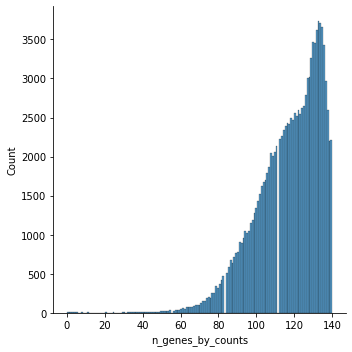

In [14]:
sns.displot(filtered["prot"].obs.n_genes_by_counts)

As the cells falling below a certain threshold of present ADT markers and not following the distribution are probably not viable cells, we want to filter out those cells.
Thus, we look at the lower end of the distribution.

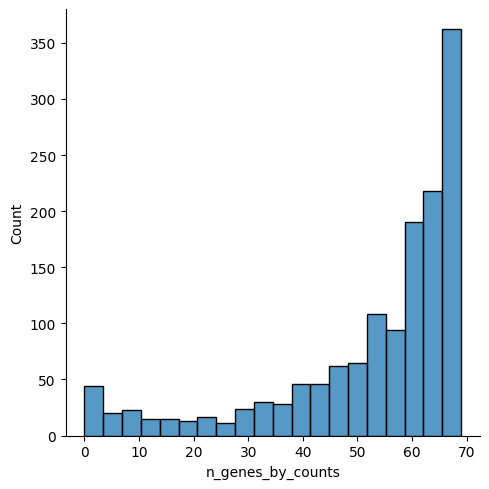

In [15]:
sns.displot(
    filtered["prot"][filtered["prot"].obs.n_genes_by_counts < 70].obs.n_genes_by_counts
)

We can see a 'valley' in the distribution at around 55 ADTs. This looks like an appropriate cutoff.

Next, we do the same thing based on total counts per cell. Looking at the total range, we can't see any apparent ranges of the disribution of counts.

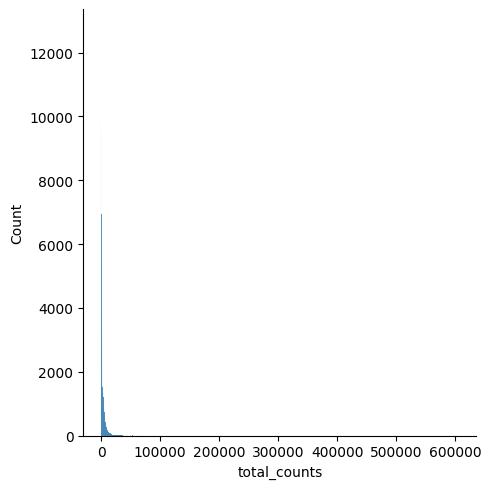

In [16]:
sns.displot(filtered["prot"].obs.total_counts)

We zoom in to see the upper end of the distribution for the total counts to decide on a cutoff for the maximum number of counts as droplets exceeding a certain threshold probably contain multiple cells, so called doublets.

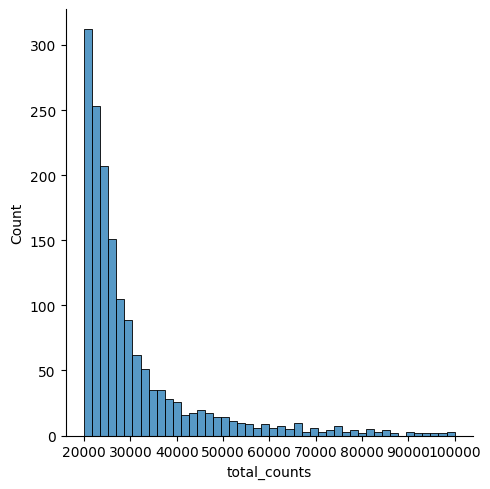

In [17]:
sns.displot(
    filtered["prot"]
    .obs.query("total_counts>20000 and total_counts<100000")
    .total_counts
)

For the `dsb` normalization performed later, we need to take a look at the raw rna count distribution. The first large peak between 10\*\*1 and 10\*\*2.1 are droplets that don't contain cells, thus we can use this range for the dsb algorithm at a later stage.

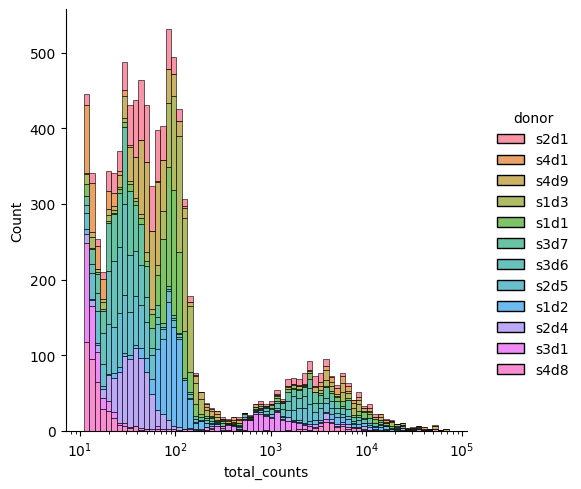

In [18]:
sns.displot(
    raw["rna"].obs.sample(frac=0.01).query("total_counts<100000 and total_counts>10"),
    x="total_counts",
    log_scale=True,
    hue="donor",
    multiple="stack",
)

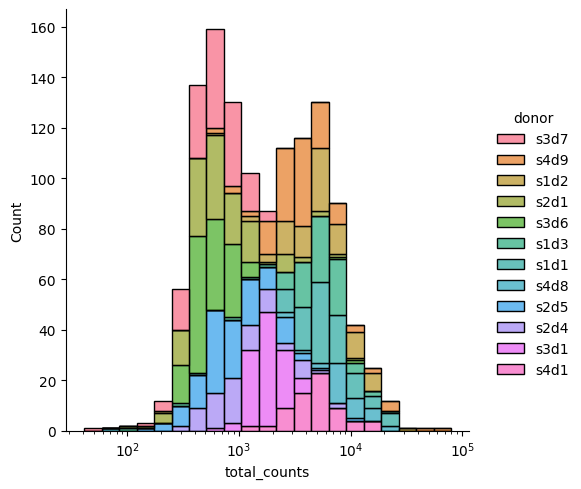

In [19]:
sns.displot(
    filtered["prot"].obs.sample(frac=0.01).query("total_counts>10"),
    x="total_counts",
    log_scale=True,
    hue="donor",
    multiple="stack",
)

In [20]:
filtered

MuData object with n_obs × n_vars = 122016 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	122016 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	122016 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Sample-wise QC

Now we look at the distribution of counts per cell across the samples to see if there are differences. As the total amount of reads and droplets can differ between the samples, a stringent, hard cutoff applied to all samples would not be appropriate.

In [21]:
sc.pp.filter_cells(filtered["prot"], max_counts=100000)

<AxesSubplot:xlabel='donor', ylabel='total_counts'>

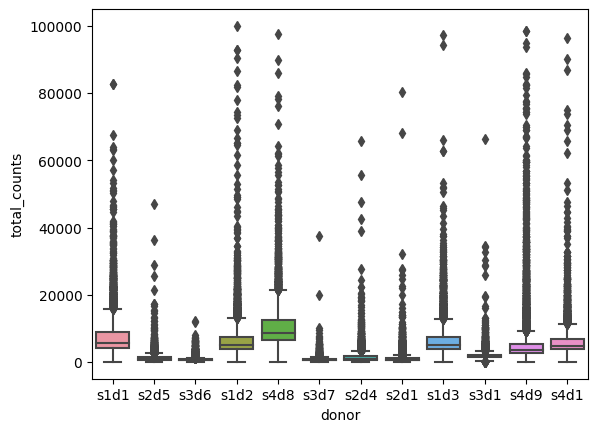

In [22]:
sns.boxplot(y=filtered["prot"].obs.total_counts, x=filtered["prot"].obs["donor"])

The distributions of counts are different between samples. Thus, sample-wise QC is deemed pertinent.
If we compare sample s3d7 vs sample s4d8, we can see that the outliers of one sample would fit the regular distribution of normal counts in the other sample.

Since we have significant number of samples we can do sample-wise QC automatically as described in the RNA preprocessing chapter.

In [23]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * M.mad()) | (
        np.median(M) + nmads * M.mad() < M
    )
    return outlier

In [24]:
%%time
outliers = []
for sample in np.unique(filtered["prot"].obs["donor"]):
    adata_temp = filtered["prot"][filtered["prot"].obs["donor"] == sample].copy()
    adata_temp.obs["outlier"] = is_outlier(
        adata_temp, "log1p_total_counts", 5
    ) | is_outlier(adata_temp, "log1p_n_genes_by_counts", 5)
    outliers.append(adata_temp.obs["outlier"])
    print(f"{sample}: outliers {adata_temp.obs.outlier.value_counts()[True]}")

s1d1: outliers 116
s1d2: outliers 103
s1d3: outliers 100
s2d1: outliers 132
s2d4: outliers 102
s2d5: outliers 104
s3d1: outliers 180
s3d6: outliers 206
s3d7: outliers 177
s4d1: outliers 81
s4d8: outliers 41
s4d9: outliers 137
CPU times: user 289 ms, sys: 34 ms, total: 323 ms
Wall time: 321 ms


In [25]:
filtered["prot"].obs["outliers"] = pd.concat(outliers)

In [26]:
filtered["prot"].obs

,donor,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,n_counts,outliers
AAACCCAAGGATGGCT-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,124,4.828314,6483.0,8.777093,6483.0,False
AAACCCAAGGCCTAGA-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,140,4.948760,19711.0,9.888983,19711.0,False
AAACCCAAGTGAGTGC-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,120,4.795791,3349.0,8.116715,3349.0,False
AAACCCACAAGAGGCT-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,128,4.859812,7841.0,8.967249,7841.0,False
AAACCCACATCGTGGC-1-0-0-0-0-0-0-0-0-0-0-0,s1d1,0,114,4.744932,2462.0,7.809135,2462.0,False
...,...,...,...,...,...,...,...,...
TTTGTTGGTCCAATCA-1-1,s4d1,1,130,4.875197,3493.0,8.158802,3493.0,False
TTTGTTGGTGACTAAA-1-1,s4d1,1,134,4.905275,4227.0,8.349484,4227.0,False
TTTGTTGTCCCTCTCC-1-1,s4d1,1,135,4.912655,7294.0,8.894944,7294.0,False
TTTGTTGTCTAGAGCT-1-1,s4d1,1,130,4.875197,3813.0,8.246434,3813.0,False


Let's first update our MuData (.obs and .var) with the data from all the modalities.

In [27]:
filtered.update()

In [28]:
filtered = filtered[filtered.obs.loc[filtered["prot"].obs_names].index]

In [29]:
filtered = filtered[filtered["prot"].obs["outliers"] == False]

In [30]:
filtered

View of MuData object with n_obs × n_vars = 120502 × 36741
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	120502 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	120502 x 140
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

We removed 1500 cells during the filtering which equates to roughly 1% of cells. This is a relatively permissive filtering and we might need further filtering of doublets in the following.

<AxesSubplot:xlabel='donor', ylabel='total_counts'>

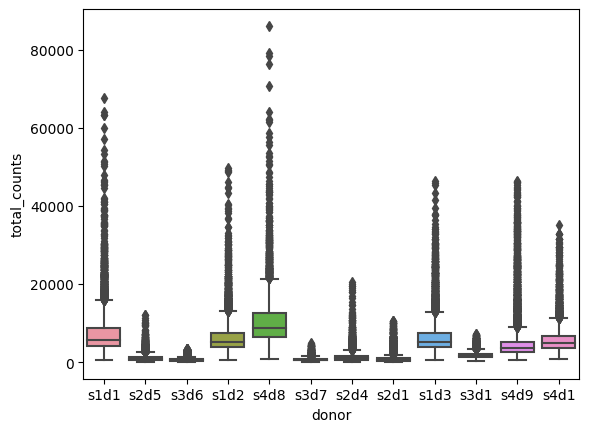

In [31]:
sns.boxplot(y=filtered["prot"].obs.total_counts, x=filtered["prot"].obs["donor"])

As we can see in the above plot, outliers are now filtered out for each sample separately. To now bring the values for each sample into a similar range, we need to normalize the data.

### Doublet exclusion

We are now going to look at cell type markers that are mutually exclusive. Some examples are CD3 (T cell marker) vs CD19 (B cell marker) to identify T/B cells doublets.
As cells expressing both specific B and T cell markers do not exist in the physiological condition, those droplets most likely contain more than one cell.

The same is true for cells both expressing T cell (CD3) and Monocyte (CD14) markers.

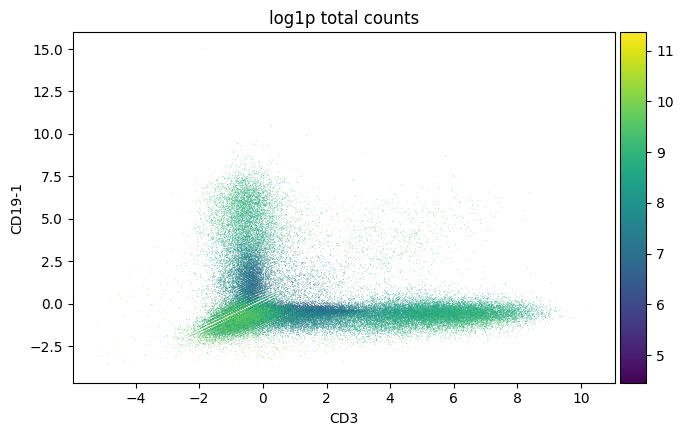

In [48]:
sc.pl.scatter(filtered["prot"], x="CD3", y="CD19-1", color="log1p_total_counts")

In this plot, we can see a large amount of cells not expressing T or B cell markers in the lower left, cells expressing only one marker in the upper left and lower right as well as some cells expressing both markers (upper right).

The cells expressing both markers are most likely doublets and can be removed.

We can also use CD3 and CD14 to detect T/Monocytes doublets.

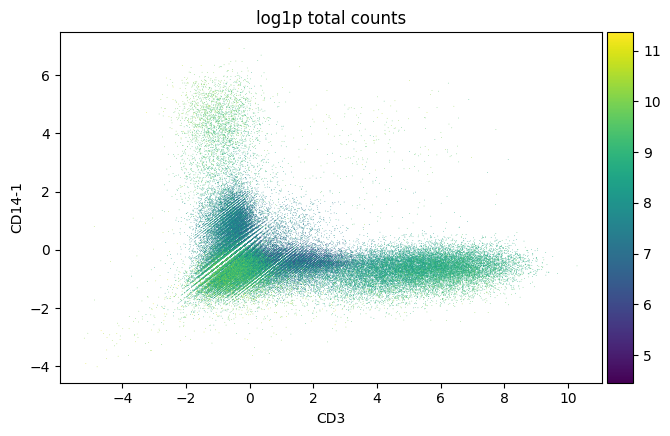

In [49]:
sc.pl.scatter(filtered["prot"], x="CD3", y="CD14-1", color="log1p_total_counts")

It looks like the change in distribution is around 2.5. We could use an expression level above 2.5 of at least two incompatible markers as our threshold to flag doublets.

In [102]:
genes2filter = ["CD3", "CD19-1", "CD14-1"]
temp = filtered["prot"][:, genes2filter].X.T.tolist()

In [125]:
filtered["prot"].obs["doublets_markers"] = [
    (temp[0][i] > 2.5 and temp[1][i] > 2.5) or (temp[0][i] > 2.5 and temp[2][i] > 2.5)
    for i in range(filtered.shape[0])
]
filtered["prot"].obs["doublets_markers"] = (
    filtered["prot"].obs["doublets_markers"].astype(str)
)

We leave out cells expressing both markers.

/home/icb/ciro.suastegui/miniconda3/envs/citeseq_pp/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'doublets_markers' as categorical


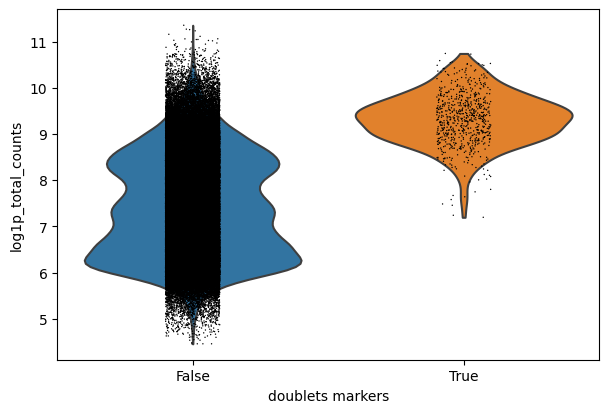

In [126]:
sc.pl.violin(filtered["prot"], keys="log1p_total_counts", groupby="doublets_markers")

Doublets usually have a higher count due to the presence of increased counts from more than one cell. We can see this effect in the cells classified as doublets using our markers.

In [27]:
filtered.update()

In [28]:
filtered = filtered[filtered.obs.loc[filtered["prot"].obs_names].index]

In [131]:
filtered = filtered[filtered["prot"].obs["doublets_markers"] == "False"]

In [132]:
filtered

View of MuData object with n_obs × n_vars = 119826 × 36737
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	119826 x 36601
      obs:	'donor', 'batch'
      var:	'gene_ids', 'feature_types'
    prot:	119826 x 136
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors'
      obsm:	'X_isotypes'
      layers:	'counts'

## Key takeaways

TODO

## References

```{bibliography}
:filter: docname in docnames
```